In [1]:
# Standard library
import os
import sys
import re
import json
import pickle
import glob
import ast
import warnings
from pathlib import Path
import importlib

# Add custom path
sys.path.append('/root/capsule/code/beh_ephys_analysis')

# Scientific libraries
import numpy as np
print(np.__version__)
import pandas as pd
print(pd.__version__)
import xarray as xr
import scipy.signal as signal
from scipy import stats
from statsmodels.stats.multitest import multipletests
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Plotting
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
from matplotlib.lines import Line2D
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colormaps
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# SpikeInterface
import spikeinterface.full as si
import spikeinterface.extractors as se
import spikeinterface.preprocessing as spre
import spikeinterface.postprocessing as spost
import spikeinterface.widgets as sw

# Progress bar
from tqdm import tqdm

# IPython display
from IPython.display import clear_output

# Open Ephys
from open_ephys.analysis import Session

# AIND analysis and utils
from aind_dynamic_foraging_basic_analysis.licks.lick_analysis import load_nwb
from aind_dynamic_foraging_data_utils.nwb_utils import load_nwb_from_filename
from aind_ephys_utils import align, sort

# Local utilities
import utils.analysis_funcs as af
import utils.plotting_funcs as pf
from utils.beh_functions import session_dirs
# from utils.plot_utils import shiftedColorMap, template_reorder, plot_raster_bar, merge_pdfs

# Warnings
warnings.filterwarnings("ignore")

# Matplotlib inline for Jupyter
%matplotlib inline

# Confirm version
print(si.__version__)
print('Finished loading packages')

2.1.3
2.3.1
0.103.0
Finished loading packages


In [2]:
from antidromic_funcs import antidromic_latency_jitter, collision_test, plot_opto_responses, analyze_antidromic_responses
import importlib
import antidromic_funcs
importlib.reload(antidromic_funcs)
from antidromic_funcs import antidromic_latency_jitter, collision_test, plot_opto_responses, analyze_antidromic_responses

from extract_raw_traces_func import extract_trial_df
# importlib.reload(extract_raw_traces_func)

In [4]:
## Load session data 
# root_folder = '/root/capsule/data/LC-NE_scratch_data_06-14-2025'
root_folder = '/root/capsule/scratch'
session_assets = pd.read_csv('/root/capsule/code/data_management/session_assets.csv')
session_list = session_assets['session_id'][:105]
results_folder = '/root/capsule/scratch/antidromic'

In [6]:
concatenate_antidromic_results = pd.DataFrame()
for session in session_assets['session_id'][:105]: 
        # session = 'behavior_754897_2025-03-13_11-20-42'
    print(session)
    subject_id = session.split('_')[1]
    session_id = '_'.join(session.split('_')[1:3])
    print(session_id)
    session_dir = session_dirs(session)
    data_type = 'curated'
    target = 'soma'
    opto_data_folder = rf'{root_folder}/{subject_id}/{session}/ephys/opto/{data_type}'
    # /root/capsule/data/LC-NE_scratch_data_06-14-2025/754897/behavior_754897_2025-03-13_11-20-42/ephys/opto/curated/behavior_754897_2025-03-13_11-20-42_curated_soma_opto_tagging_summary.pkl
    # load opto tagging data
    try:
        with open(os.path.join(opto_data_folder, f'{session}_curated_soma_opto_tagging_summary.pkl'), 'rb') as f:        
            unit_tbl = pickle.load(f)
        opto_units = unit_tbl.query("opto_pass == True & default_qc == True")["unit_id"].to_list()

        # data/LC-NE_scratch_data_06-14-2025/754897/behavior_754897_2025-03-13_11-20-42/ephys/curated/processed
        print (f"opto units: {(opto_units)}")

        spike_times_folder = rf'{root_folder}/{subject_id}/{session}/ephys/{data_type}/processed'
        with open(os.path.join(spike_times_folder, 'spiketimes.pkl'), 'rb') as f:
            spiketimes = pickle.load(f)
            print('spiketime loaded')
        

        start = np.min(np.array([np.min(spiketimes[unit]) for unit in spiketimes.keys()]))
        end = np.max(np.array([np.max(spiketimes[unit]) for unit in spiketimes.keys()]))
        # Load opto event data
        opto_event_file = Path(f'{opto_data_folder}/{session}_opto_session.csv')
        event_ids = pd.read_csv(opto_event_file)        

        merged_df = analyze_antidromic_responses(opto_units, spiketimes, event_ids)
        # Create a new DataFrame with a 'session' column
        session_df = pd.DataFrame({'session': [session] * len(merged_df)})

        ## Ensure the directory exists
        
        output_dir = os.path.join(results_folder, 'results')
        os.makedirs(output_dir, exist_ok=True)

        # Merge the new DataFrame with merged_df
        merged_df = pd.concat([session_df, merged_df], axis=1)
        
        # Save the file
        merged_df.to_pickle(os.path.join(output_dir, f'{session}_antidromic_results.pkl'))
        # print(merged_df)
       
        concatenate_antidromic_results = pd.concat([concatenate_antidromic_results, merged_df], ignore_index=True)
        
        print() 
    except:
        print('Error')

concatenate_antidromic_results.to_pickle(os.path.join(results_folder, 'concatenate_antidromic_results.pkl'))

print(os.path.join(results_folder, 'concatenate_antidromic_results.pkl'))

ecephys_713854_2024-03-05_12-01-40
713854_2024-03-05
opto units: [52, 53, 59, 64, 65]
spiketime loaded
No antidromic results found.
Error
ecephys_713854_2024-03-05_13-01-09
713854_2024-03-05
opto units: [0, 3, 4, 9, 11, 15, 17, 27, 29, 137, 141, 167, 169, 171]
spiketime loaded
No antidromic results found.
Error
ecephys_713854_2024-03-05_13-31-20
713854_2024-03-05
opto units: [0, 5, 6, 13, 17, 18, 28, 163, 176, 232]
spiketime loaded
Unit 17 is categorized as tier 2 for site surface_PrL with antidromic latency: 0.06049999999999995 and jitter: 0.0 and collision_pvalue: 1.0 and collision_pbinom: 1.0
Unit 163 is categorized as tier 2 for site surface_PrL with antidromic latency: 0.008499999999999997 and jitter: 0.005999999999999995 and collision_pvalue: 1.0 and collision_pbinom: nan
   unit_id  tier                site_for_tier
0        0     0  surface_PrL_antidromic_tier
1        5     0  surface_PrL_antidromic_tier
2        6     0  surface_PrL_antidromic_tier
3       13     0  surface_P

In [ ]:
filepath = os.path.join(results_folder, 'concatenate_antidromic_results.pkl')
with open(filepath, 'rb') as f:
    concatenate_antidromic_results = pickle.load(f)


In [14]:
concatenate_antidromic_results['session'].unique()

array(['ecephys_713854_2024-03-05_13-31-20',
       'ecephys_717120_2024-03-06_12-54-27',
       'ecephys_713854_2024-03-08_15-43-01',
       'ecephys_684930_2023-09-28_12-44-15',
       'behavior_716325_2024-05-31_10-31-14',
       'behavior_751004_2024-12-21_13-28-28',
       'behavior_751004_2024-12-23_14-20-03',
       'behavior_751769_2025-01-16_11-32-05',
       'behavior_751769_2025-01-17_11-37-39',
       'behavior_751769_2025-01-18_10-15-25',
       'behavior_758017_2025-02-06_11-26-14',
       'behavior_758017_2025-02-07_14-11-08',
       'behavior_751766_2025-02-11_11-53-38',
       'behavior_751766_2025-02-13_11-31-21',
       'behavior_751766_2025-02-14_11-37-11',
       'behavior_751181_2025-02-26_11-51-19',
       'behavior_751181_2025-02-27_11-24-47',
       'behavior_754897_2025-03-11_12-07-41',
       'behavior_754897_2025-03-12_12-23-15',
       'behavior_754897_2025-03-13_11-20-42',
       'behavior_754897_2025-03-14_11-28-53'], dtype=object)

In [8]:
concatenate_antidromic_results 
# antidromic_tier_columns = [col for col in concatenate_antidromic_results.columns if 'antidromic_tier' in col]
# print(antidromic_tier_columns)

## antidromic unit summary (columns: session, unit_id, site, tier, antidromic_latency, jitter, collision_pvalue, collision_pbinom)
summary_rows = []
for idx, row in concatenate_antidromic_results.iterrows():
    for site in ['surface_PrL', 'surface_S1', 'surface_V1', 'surface_SC']:
        opto_p_value_col = f'opto_p_val_{site}'
        tier_col = f"{site}_antidromic_tier"
        latency_col = f"antidromic_latency_{site}"
        jitter_col = f"jitter_{site}"
        collision_pvalue_col = f"collision_pvalue_{site}"
        collision_pbinom_col = f"collision_pbinom_{site}"
        pre_boundary_prob_col = f'pre_boundary_prob_{site}'
        post_boundary_prob_col = f'post_boundary_prob_{site}'
        Avg_col = f'Avg_{site}'
        if tier_col in row and not pd.isna(row[tier_col]):
            summary_rows.append({
                'session': row['session'],
                'unit_id': row['unit_id'],
                'site': site,
                'tier': row[tier_col],
                'antidromic_latency': row.get(latency_col, np.nan),
                'jitter': row.get(jitter_col, np.nan),
                'opto_pvalue': row.get(opto_p_value_col, np.nan),
                'collision_pvalue': row.get(collision_pvalue_col, np.nan),
                'collision_pbinom': row.get(collision_pbinom_col, np.nan),
                'pre_boundary_prob': row.get(pre_boundary_prob_col, np.nan),
                'post_boundary_prob': row.get(post_boundary_prob_col, np.nan),
                'Avg': row.get(Avg_col, np.nan), 

            })
antidromic_unit_summary = pd.DataFrame(summary_rows)
antidromic_unit_summary 

# plot histogram of antidromic tiers
tier_summary = antidromic_unit_summary['tier'].value_counts().reset_index()   
# tier_summary.columns = ['tier', 'count']
tier_summary.columns = ['tier', 'count']    



In [10]:
antidromic_unit_summary.to_csv(os.path.join(results_folder, 'antidomic_unit_summary.csv'))

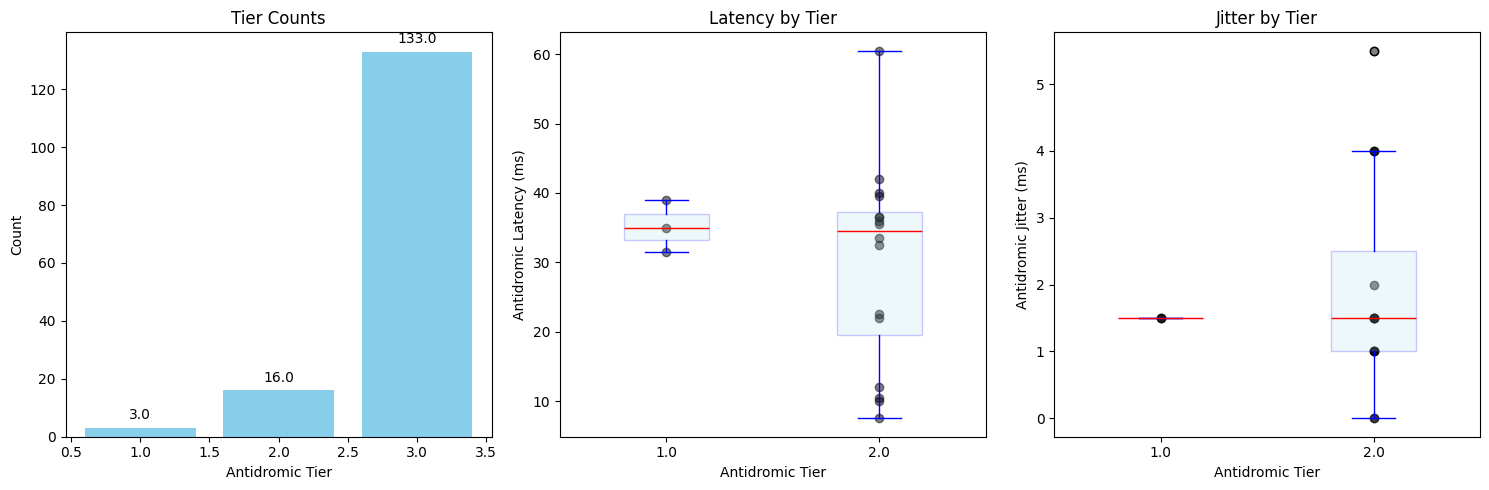

In [13]:
# Plot histogram, latency, and jitter distributions in one figure

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Bar plot of tier counts
axes[0].bar(tier_summary['tier'], tier_summary['count'], color='skyblue')
axes[0].set_xlabel('Antidromic Tier')
axes[0].set_ylabel('Count')
axes[0].set_title('Tier Counts')
for i, row in tier_summary.iterrows():
    axes[0].text(row['tier'], row['count'] + 2, str(row['count']), ha='center', va='bottom', fontsize=10)

# Box plot for antidromic latency
for tier in tier_summary['tier']:
    if tier < 3:
        tier_data = antidromic_unit_summary[antidromic_unit_summary['tier'] == tier]
        if not tier_data.empty:
            axes[1].boxplot(
                tier_data['antidromic_latency'] * 1000, positions=[tier], widths=0.4,
                patch_artist=True,
                boxprops=dict(facecolor='lightblue', color='blue', alpha=0.2),
                medianprops=dict(color='red'),
                whiskerprops=dict(color='blue'),
                capprops=dict(color='blue')
            )
            axes[1].scatter([tier] * len(tier_data['antidromic_latency']), tier_data['antidromic_latency'] * 1000, color='black', alpha=0.5)
axes[1].set_xlabel('Antidromic Tier')
axes[1].set_ylabel('Antidromic Latency (ms)')
axes[1].set_title('Latency by Tier')

# Box plot for antidromic jitter
for tier in tier_summary['tier']:
    if tier < 3:
        tier_data = antidromic_unit_summary[antidromic_unit_summary['tier'] == tier]
        if not tier_data.empty:
            axes[2].boxplot(
                tier_data['jitter'] * 1000, positions=[tier], widths=0.4,
                patch_artist=True,
                boxprops=dict(facecolor='lightblue', color='blue', alpha=0.2),
                medianprops=dict(color='red'),
                whiskerprops=dict(color='blue'),
                capprops=dict(color='blue')
            )
            axes[2].scatter([tier] * len(tier_data['jitter']), tier_data['jitter'] * 1000, color='black', alpha=0.5)
axes[2].set_xlabel('Antidromic Tier')
axes[2].set_ylabel('Antidromic Jitter (ms)')
axes[2].set_title('Jitter by Tier')

plt.tight_layout()


In [14]:
antidromic_unit_summary.to_csv(os.path.join(results_folder, 'antidromic_unit_summary.csv'), index=False)

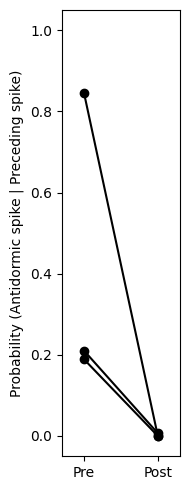

t-statistic: 1.906786223658371, p-value: 0.19680144106281722


In [15]:
# line-Plot pre_boundary_prob and post_boundary_prob for each tier 1 unit (row)
tier1 = antidromic_unit_summary.query('tier == 1')
plt.figure(figsize=(2, 5))
for idx, row in tier1.iterrows():
    plt.plot(['Pre', 'Post'], [row['pre_boundary_prob'], row['post_boundary_prob']],
             marker='o', label=f"Unit {int(row['unit_id'])}-{row['site']}",color='black')
plt.ylabel('Probability (Antidormic spike | Preceding spike)')
plt.xlim(-0.3, 1.3)
plt.ylim(-0.05, 1.05)
# plt.title('')
# plt.legend()
plt.tight_layout()
plt.show()

# run pairwise t-test for pre_boundary_prob and post_boundary_prob for each tier 1 unit (row)
from scipy.stats import ttest_rel   
pre_prob = tier1 ['pre_boundary_prob']
post_prob = tier1 ['post_boundary_prob']
t_stat, p_value = ttest_rel(pre_prob, post_prob)
print(f"t-statistic: {t_stat}, p-value: {p_value}")

In [16]:
pre_prob 

38     0.846154
46     0.210526
114    0.189189
Name: pre_boundary_prob, dtype: float64

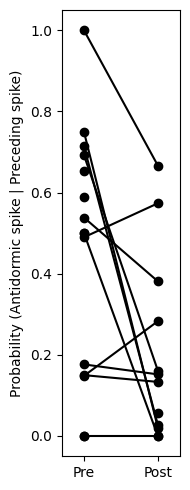

ValueError: Array shapes are incompatible for broadcasting.

In [17]:
# line-Plot pre_boundary_prob and post_boundary_prob for each tier 2 unit (row)
tier2 = antidromic_unit_summary.query('tier == 2')
plt.figure(figsize=(2, 5))
for idx, row in tier2.iterrows():
    plt.plot(['Pre', 'Post'], [row['pre_boundary_prob'], row['post_boundary_prob']],
             marker='o', label=f"Unit {int(row['unit_id'])}-{row['site']}",color='black')
plt.ylabel('Probability (Antidormic spike | Preceding spike)')
plt.xlim(-0.3, 1.3)
plt.ylim(-0.05, 1.05)
# plt.title('')
# plt.legend()
plt.tight_layout()
plt.show()

# run pairwise t-test for pre_boundary_prob and post_boundary_prob for each tier 2 unit (row)
from scipy.stats import ttest_rel   
pre_prob = tier2 ['pre_boundary_prob'].dropna()
post_prob = tier2 ['post_boundary_prob'].dropna()
t_stat, p_value = ttest_rel(pre_prob, post_prob)
print(f"t-statistic: {t_stat}, p-value: {p_value}")

Checking unit 288.0 at site surface_S1 in session behavior_751769_2025-01-17_11-37-39
[array([-0.02657253]), array([-0.05791612,  0.03431721]), array([-0.04032466,  0.03454201]), array([0.01830199]), array([-0.07466401,  0.03480473]), array([-0.09774414,  0.03472253]), array([-0.02147482]), array([-0.05499005,  0.03484328]), array([-0.07214415,  0.03495382]), array([-0.07162899,  0.03480587]), array([-0.07555407,  0.03491101]), array([-0.02443493]), array([0.00792861]), array([0.01579447]), array([0.02536506]), array([0.01600355]), array([0.01848003]), array([-0.07338337,  0.03521663]), array([-0.09745297,  0.03531621]), array([-0.00584874]), array([0.01859082]), array([0.01678831]), array([-0.04709721,  0.0354016 ]), array([0.02126667]), array([0.0112849]), array([-0.0925302,  0.0370698]), array([-0.06173271]), array([0.02275192]), array([0.00752207]), array([-0.00594895]), array([-0.08227708,  0.02612292]), array([0.01535087]), array([0.01948555]), array([-0.09447227,  0.03646106]), 

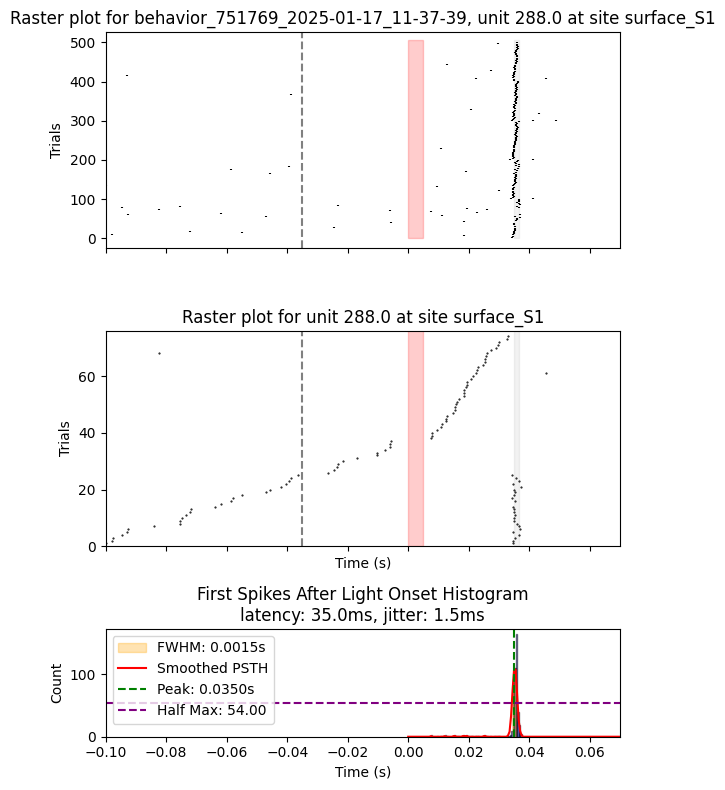

Fisher's exact test p-value: 4.123e-08
Collision detected between antidromic and orthodromic spikes
Checking unit 29.0 at site surface_S1 in session behavior_751769_2025-01-18_10-15-25
[array([0.02897964]), array([0.01201461]), array([-0.03972506]), array([0.02255174]), array([0.03179022]), array([-0.05479371,  0.06807596]), array([-0.08149773,  0.03026893]), array([-0.07739225]), array([0.02867947]), array([0.01400495]), array([-0.07764135]), array([-0.00140305]), array([-0.01854269]), array([0.03698964]), array([0.01676007]), array([-0.09434835,  0.05078628]), array([-0.05844402]), array([-0.08356157]), array([-0.04608131]), array([-0.05937117]), array([-0.08869028]), array([-0.04813281]), array([-0.0552593]), array([0.02853168]), array([-0.05626767]), array([0.03097905]), array([-0.08720534]), array([-0.00487461,  0.04839138]), array([-0.03563158]), array([0.01844803]), array([-0.05891457,  0.04518543]), array([-0.097293  , -0.04785847]), array([-0.01654974]), array([0.02859503]), a

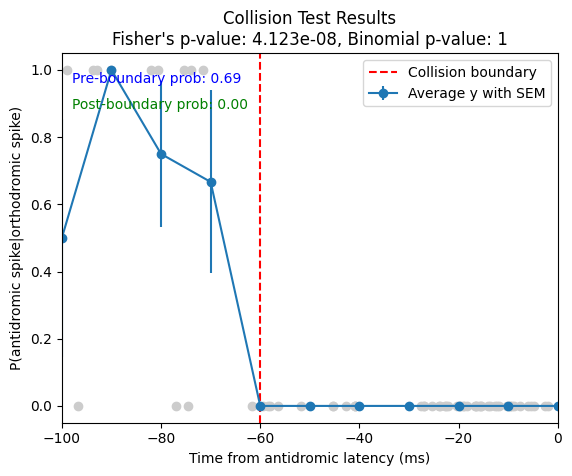

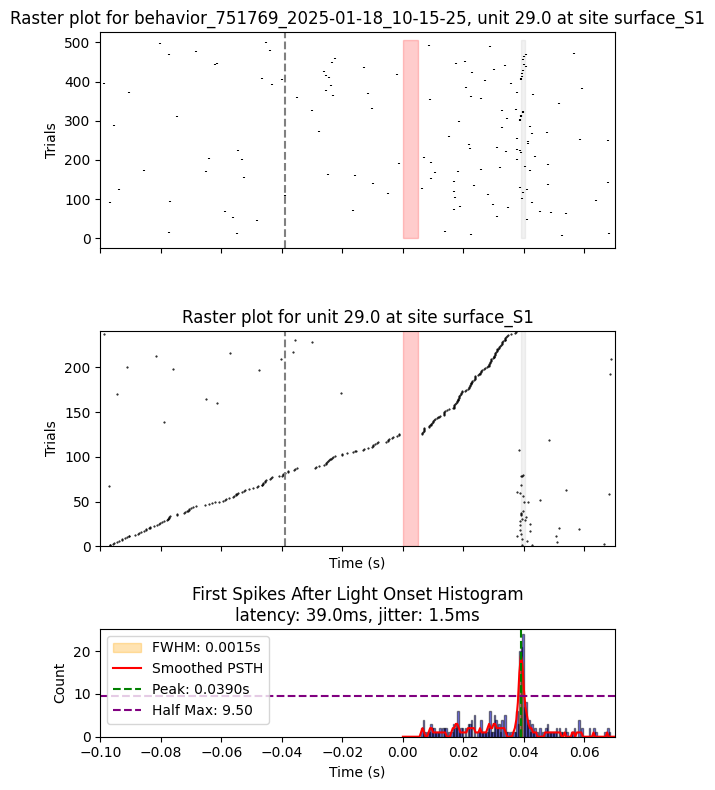

Fisher's exact test p-value: 5.422e-05
Collision detected between antidromic and orthodromic spikes
Checking unit 46.0 at site surface_S1 in session behavior_751181_2025-02-27_11-24-47
[array([0.02195663]), array([-0.04386767]), array([0.02221414]), array([-0.02975458,  0.06114541]), array([-0.07401752]), array([-0.00296452]), array([-0.08306285,  0.03927143]), array([-0.09490139,  0.03826187]), array([0.01805515]), array([-0.00799049]), array([-0.05199605]), array([-0.08349303,  0.03817294]), array([0.0064833]), array([0.00912242, 0.06009   ]), array([0.01319043]), array([-0.07040055]), array([-0.03230029]), array([0.02123772]), array([-0.08678874]), array([-0.08761494,  0.04515144]), array([-0.05192725,  0.03877275]), array([-0.01530105]), array([-0.06866022]), array([-0.00743253]), array([0.00764369]), array([-0.09785975,  0.03817358]), array([0.01390121]), array([-0.00582821]), array([0.02699339]), array([-0.0246469]), array([-0.06452805,  0.03787338]), array([-0.02584088]), array(

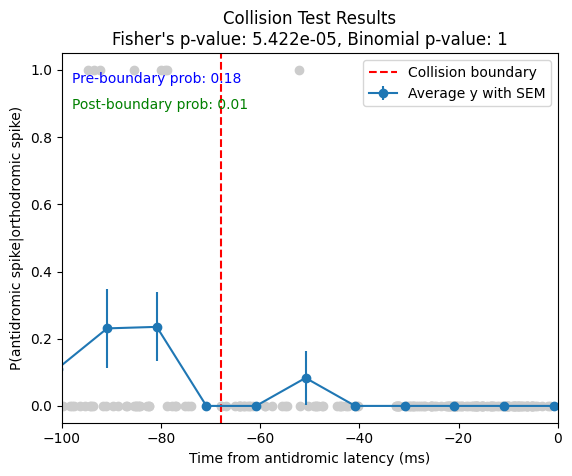

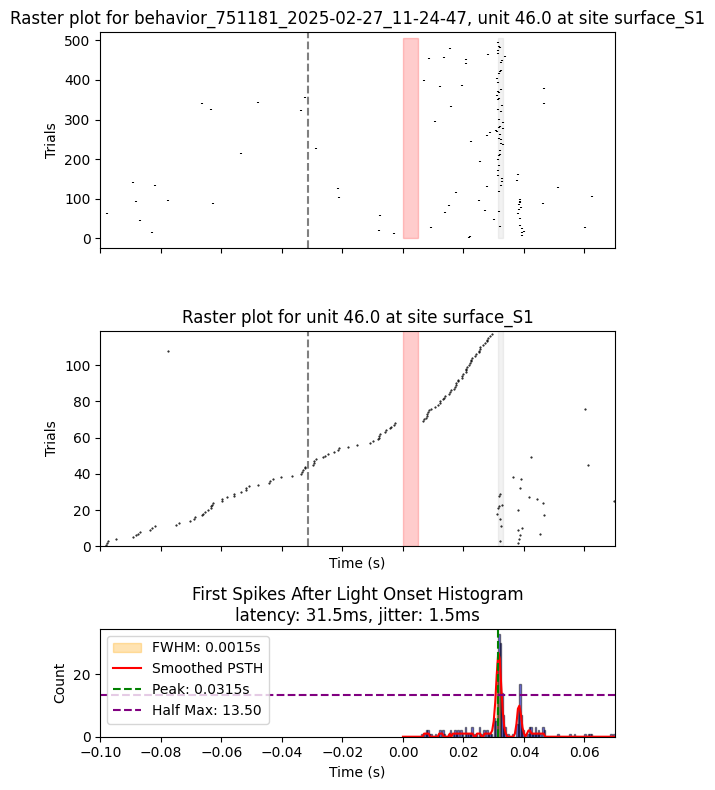

Fisher's exact test p-value: 0.001834
Collision detected between antidromic and orthodromic spikes


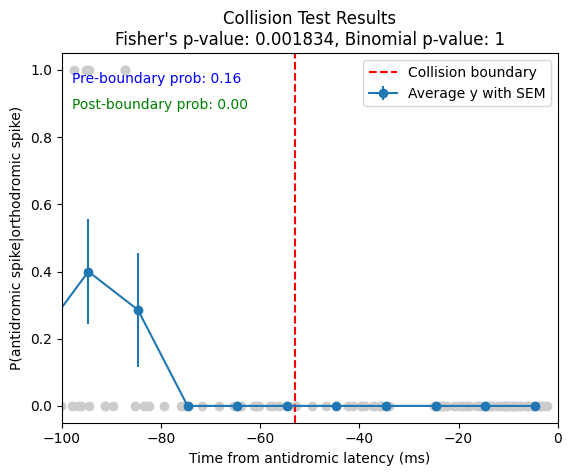

In [18]:
import numpy as np

from antidromic_funcs import antidromic_latency_jitter, collision_test
import importlib
import antidromic_funcs
importlib.reload(antidromic_funcs)

# Plot antidromic raster from int_event_locked_timestamps
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from scipy.ndimage import gaussian_filter1d
import utils.plotting_funcs as pf
importlib.reload(pf)


# Checking antidromic unit responses
def check_antidromic_responses(unit_id, site, session,concatenate_antidromic_results):
    # extract int_event_locked_timestamps for the unit_id and site and session
    unit_data = concatenate_antidromic_results[(concatenate_antidromic_results['unit_id'] == unit_id) & 
        (concatenate_antidromic_results['session'] == session)]
    if unit_data.empty:
        print(f"No data found for unit {unit_id} at site {site} in session {session}.")
        return None
    int_event_locked_timestamps = unit_data[f'int_event_locked_timestamps_{site}'].values[0]

    return int_event_locked_timestamps

def plot_collision_raster(int_event_locked_timestamps, time_range_raster=(-0.1, 0.07)):    
    import matplotlib.patches as patches
    # Calculate antidromic_latency and antidromic_jitter
    antidromic_latency, antidromic_jitter = antidromic_latency_jitter(int_event_locked_timestamps)
    first_spikes_after_light = np.array([arr[arr > 0][0] for arr in int_event_locked_timestamps if np.any(arr > 0)])

    # Create figure with two subplots sharing x-axis
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 8), sharex=True, gridspec_kw={'height_ratios': [2, 2, 1]})

    # Raster plot
    ax = ax1
    ax.set_title(f'Raster plot for {session}, unit {unit_id} at site {site}')
    
    for i, spikes in enumerate(int_event_locked_timestamps):
        if len(spikes) > 0:
            ax.vlines(spikes, i + 0.5, i + 1.5, color='black')

    ax.set_xlim(time_range_raster)
    ax.set_ylabel('Trials')

    # Red box between 0 and 0.005 sec
    ax.add_patch(patches.Rectangle((0, 0), 0.005, len(int_event_locked_timestamps)+5, 
                                    linewidth=1, edgecolor='red', facecolor='red', alpha=0.2))
    # Gray box for latency/jitter
    ax.add_patch(patches.Rectangle((antidromic_latency, 0), antidromic_jitter, len(int_event_locked_timestamps)+5, 
                                    linewidth=1, edgecolor='gray', facecolor='gray', alpha=0.1))
    ax.axvline(x=-antidromic_latency, color='gray', linestyle='--', label='Collision boundary')

    


    int_event_locked_timestamps_roi_trials = [
    spike_times for spike_times in int_event_locked_timestamps
    if spike_times.size > 0 and np.any(spike_times <= antidromic_latency - antidromic_jitter)   
    ]

    print(int_event_locked_timestamps_roi_trials)
    int_event_locked_timestamps_df = pd.DataFrame({
    'trial': range(len(int_event_locked_timestamps_roi_trials)),
    'spike_times': [list(trial) for trial in int_event_locked_timestamps_roi_trials],
    'last_orthodromic_spike_time': [np.max(trial[trial < antidromic_latency - antidromic_jitter]) if np.any(trial < antidromic_latency - antidromic_jitter) else None for trial in int_event_locked_timestamps_roi_trials],
    })
    
    # plot raster for spike times for int_event_locked_timestamps_roi_trials based on the last_orthodromic_spike_time
    # fig, ax = plt.subplots(figsize=(6, 3))
    ax = ax2
    int_event_locked_timestamps_df = int_event_locked_timestamps_df.sort_values(by='last_orthodromic_spike_time', ascending=True)
    int_event_locked_timestamps_df['last_orthodromic_spike_time'] = pd.to_numeric(int_event_locked_timestamps_df['last_orthodromic_spike_time'], errors='coerce')
    int_event_locked_timestamps_df = int_event_locked_timestamps_df.dropna(subset=['last_orthodromic_spike_time'])
    int_event_locked_timestamps_df['last_orthodromic_spike_time'] = int_event_locked_timestamps_df['last_orthodromic_spike_time'].astype(float)

    pf.raster_plot(int_event_locked_timestamps_df['spike_times'].tolist(), time_range=(-0.1, 0.07), ax=ax2)
    # plot red box between 0 and 0.005 sec 
    ax.add_patch(patches.Rectangle((0, 0), 0.005, len(int_event_locked_timestamps_df)+5, 
                                    linewidth=1, edgecolor='red', facecolor='red', alpha=0.2))

    ax.add_patch(patches.Rectangle((antidromic_latency, 0), antidromic_jitter, len(int_event_locked_timestamps_df)+5, 
                                    linewidth=1, edgecolor='gray', facecolor='gray', alpha=0.1))

    ax.axvline(x=-antidromic_latency, color='gray', linestyle='--', label='Collision boundary')
    ax.set_title(f'Raster plot for unit {unit_id} at site {site}')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Trials')    
    
    ax= ax3
    # Histogram and smoothed PSTH
    bins = np.arange(0, 0.1, 0.0005)
    histogram, _ = np.histogram(first_spikes_after_light, bins=bins)
    ax.set_title('First Spikes After Light Onset Histogram\nlatency: {:.1f}ms, jitter: {:.1f}ms'.format(antidromic_latency*1000, antidromic_jitter*1000))
    ax.hist(first_spikes_after_light, bins=bins, alpha=0.5, color='blue', edgecolor='black')

    # Convolve the histogram with a Gaussian kernel
    sigma = 0.5 / 1000 / (bins[1] - bins[0])  # Convert sigma to bin units
    smoothed_psth = gaussian_filter1d(histogram, sigma)

    # Find the peak of the smoothed PSTH
    peak_index = np.argmax(smoothed_psth)
    peak_time = bins[peak_index]
    peak_value = smoothed_psth[peak_index]

    # Calculate FWHM (Full Width at Half Maximum)
    half_max = peak_value / 2
    above_half_max = np.where(smoothed_psth >= half_max)[0]
    if len(above_half_max) > 1:
        fwhm = bins[above_half_max[-1]] - bins[above_half_max[0]]
        ax.fill_between(bins[above_half_max[0]:above_half_max[-1]], smoothed_psth[above_half_max[0]:above_half_max[-1]], alpha=0.3, color='orange', label=f'FWHM: {fwhm:.4f}s')
    else:
        fwhm = 0

    # Plot the smoothed PSTH
    ax.plot(bins[:-1], smoothed_psth, label='Smoothed PSTH', color='red')
    ax.axvline(peak_time, color='green', linestyle='--', label=f'Peak: {peak_time:.4f}s')
    ax.axhline(half_max, color='purple', linestyle='--', label=f'Half Max: {half_max:.2f}')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Count')
    ax.legend()

    plt.tight_layout()
    plt.show()


for idx, row in antidromic_unit_summary.query('tier == 1').iterrows():
    unit_id = row['unit_id']
    site = row['site']
    session = row['session']
    print(f"Checking unit {unit_id} at site {site} in session {session}")
    int_event_locked_timestamps = check_antidromic_responses(unit_id, site, session, concatenate_antidromic_results)
    if int_event_locked_timestamps is not None:
        antidromic_latency, antidromic_jitter = antidromic_latency_jitter(int_event_locked_timestamps)
        first_spikes_after_light = np.array([arr[arr > 0][0] for arr in int_event_locked_timestamps if np.any(arr > 0)])        
        plot_collision_raster(int_event_locked_timestamps, time_range_raster=(-0.1, 0.07))
        collision_results = collision_test(int_event_locked_timestamps, antidromic_latency, bin_size=10, antidromic_jitter=antidromic_jitter, plot=True)



### Extract raw traces


In [22]:
### Extract raw traces
# session = 'behavior_751181_2025-02-27_11-24-47'
# unit_id = 244
# roi_site = 'surface_S1'

session = 'behavior_754897_2025-03-13_11-20-42'
unit_id = 49
roi_site = 'surface_S1'




In [23]:
from extract_raw_traces_func import extract_trial_df
import extract_raw_traces_func
importlib.reload(extract_raw_traces_func)
traces_df, int_event_locked_timestamps = extract_trial_df(session, unit_id, roi_site)
antidromic_latency, antidromic_jitter = antidromic_latency_jitter(int_event_locked_timestamps)


unit_spike_times loaded
event_csv_file loaded
antidromic_stim_times retrieved
we loaded


trace figure saved


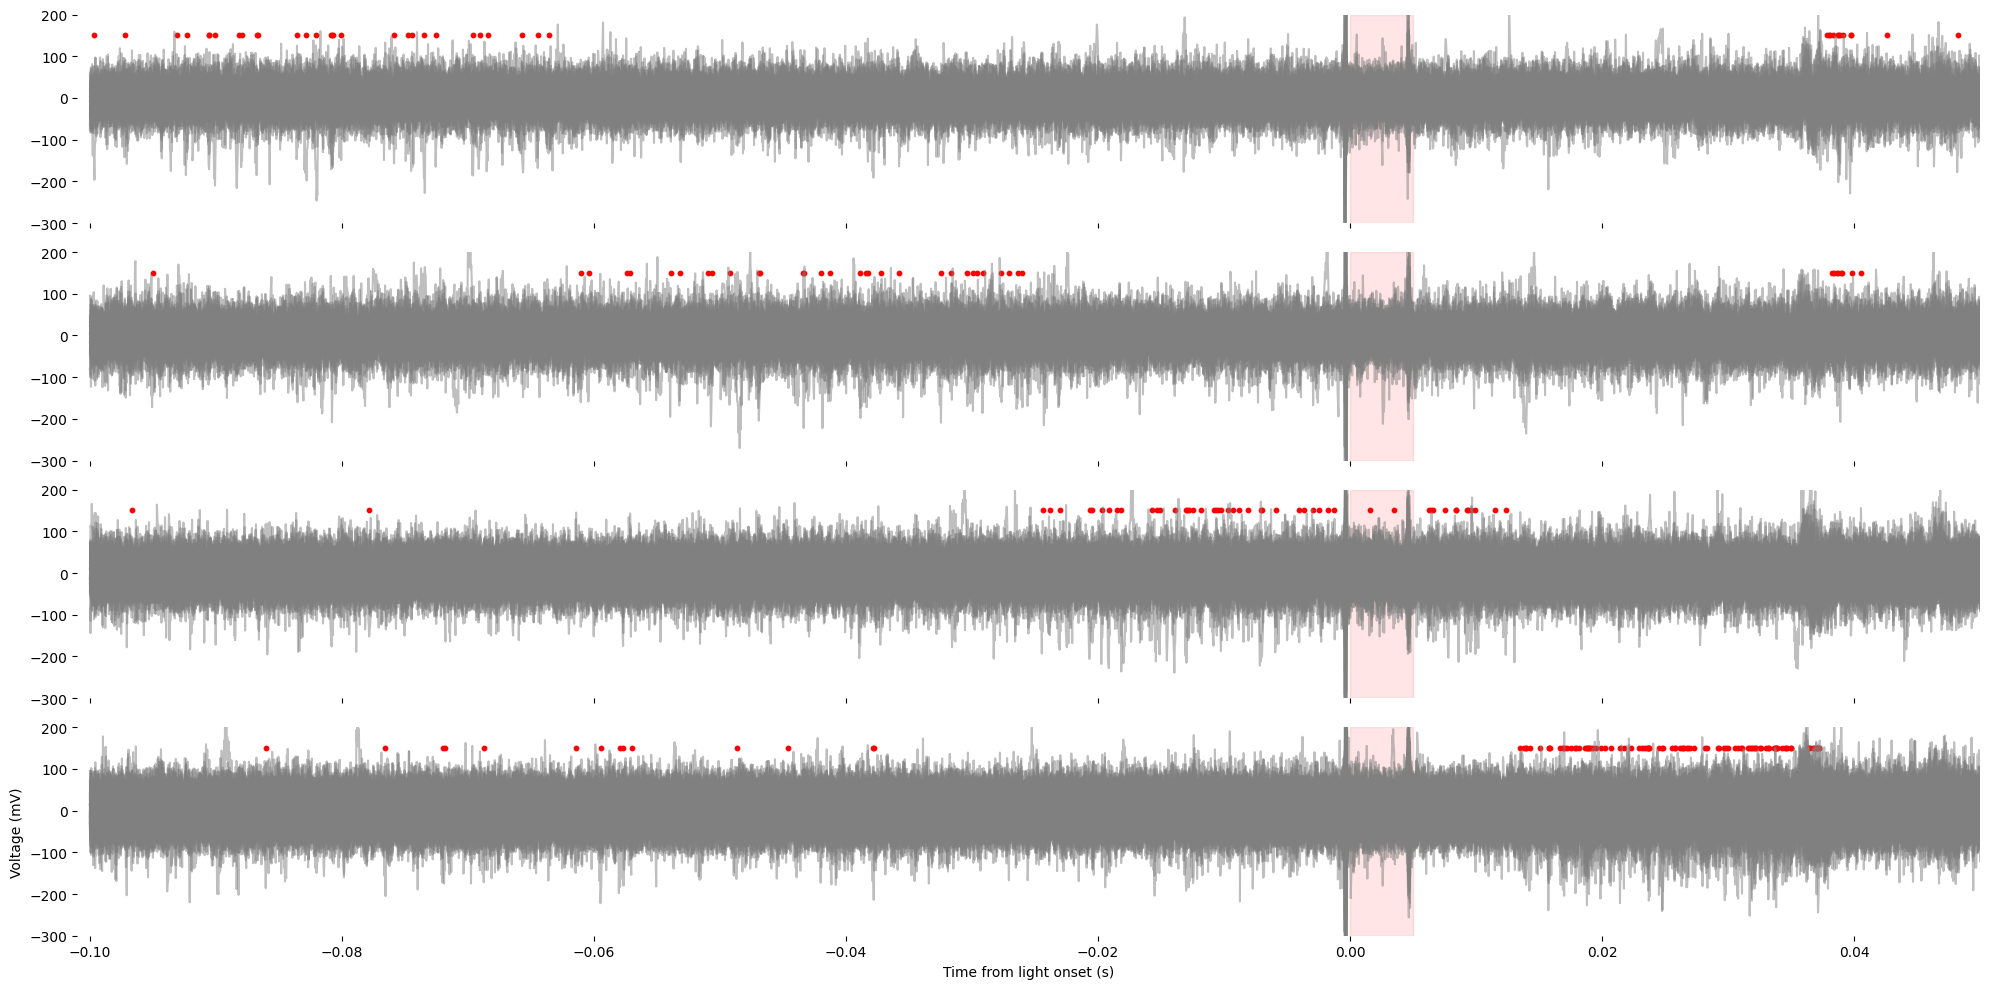

In [21]:
# Plot raw traces
trial_num = 0  # Initialize trial number
collision = None  # Initialize collision variable
results = []  # Initialize a list to store results

for spike_times in int_event_locked_timestamps:
    if spike_times.size > 0:
        # Find orthodromic and antidromic spike times
        orthodromic_spike_times = spike_times[spike_times <= antidromic_latency - antidromic_jitter]
        antidromic_spike_times = spike_times[
            (antidromic_latency - antidromic_jitter < spike_times) &
            (spike_times < antidromic_latency + antidromic_jitter)
        ]
        # Collision determination
        if orthodromic_spike_times.size > 0:
            last_orthodromic_spike_time = orthodromic_spike_times[-1]
            collision = 0 if antidromic_spike_times.size > 0 else 1
        else:
            last_orthodromic_spike_time = None
    else:
        orthodromic_spike_times = np.array([])
        antidromic_spike_times = np.array([])
        last_orthodromic_spike_time = None

    results.append({
        'trial_num': trial_num,
        'spike_times': spike_times.tolist(),
        'ortho_spike_times': orthodromic_spike_times.tolist(),
        'last_orthodromic_spike_time': last_orthodromic_spike_time,
        'anti_spike_times': antidromic_spike_times.tolist(),
        'collision': collision
    })
    trial_num += 1

# Convert results to a DataFrame for easier handling
results_df = pd.DataFrame(results)
results_df.query('last_orthodromic_spike_time.notna()').sort_values(by='last_orthodromic_spike_time')
bin_size = antidromic_latency-antidromic_jitter
edges = np.arange(-0.1, antidromic_jitter+2*bin_size, bin_size)
# edges = np.arange(-4*bin_size, 2*bin_size, bin_size)
# print(edges)
results_df['last_orthodromic_spike_time_bin'] = pd.cut(
    results_df['last_orthodromic_spike_time'],
    bins=edges,
    include_lowest=True,  
    right=False,           
    labels=False          
)

# results_df['last_orthodromic_spike_time_bin'] = (
#     results_df['last_orthodromic_spike_time'] // bin_size * bin_size
# )
grouped_trials = results_df.groupby('last_orthodromic_spike_time_bin')
results_df['group_num'] = results_df.groupby('last_orthodromic_spike_time_bin').ngroup()
# merge data and results_df
merged_results_df = pd.merge(traces_df, results_df, left_on='trial', right_on='trial_num', how='outer')

pulse_duration = 0.005
# Iterate through each group and plot x and y values
fig, axs = plt.subplots(len(results_df['group_num'].unique())-1,1, figsize=(20, 10), sharex=True, sharey=True)
for ax, (group_num, group) in zip(axs, results_df.groupby('group_num')):
    light_onset = 0.0  # Assuming light onset is at 0 seconds
    light_duration = pulse_duration  # Duration of light pulse
    ax.axvspan(light_onset, light_onset + light_duration, color='red', alpha=0.1, label='Light Duration')
    for trial_num in group['trial_num']:
        trial_data = merged_results_df.loc[merged_results_df['trial_num'] == trial_num]
        x = np.array(trial_data['x'].values[0])
        y = np.array(trial_data['y'].values[0])
        spike_times = np.array(trial_data['spike_times'].values[0])
        
        ax.plot(x, y, alpha=0.5, label=f'Trial {trial_num}', color='gray')
        ax.scatter(spike_times, np.zeros_like(spike_times) + 150, s=10, label='Spikes', color='red')
    ax.set_xlim(-0.101, 0.05)
    ax.set_ylim(-300, 200)   
    
    for spine in ax.spines.values():
        spine.set_visible(False)
ax.set_xlabel('Time from light onset (s)')
ax.set_ylabel('Voltage (mV)')
plt.tight_layout()

filename = rf'{session}_unit_{unit_id}_{roi_site}_antidromic_traces.pdf'
plt.savefig(os.path.join(results_folder, filename), dpi=300, format='pdf')
print('trace figure saved')
print(filename)



In [51]:
print(results_folder)

/root/capsule/scratch/antidromic
